In [1]:
import numpy as np
import pandas as pd
import math
import torch
import config as cfg
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from utility.survival import Survival
from tools.regressors import CoxPH, RSF, DeepSurv, DSM, BNNSurv
from tools.feature_selectors import PHSelector
from utility.builder import Builder
from tools.file_reader import FileReader
from tools.data_ETL import DataETL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines.statistics import proportional_hazard_test
from tools.evaluator import LifelinesEvaluator
from tools.Evaluations.util import predict_median_survival_time
import config as cfg
from sklearn.preprocessing import StandardScaler
from tools.formatter import Formatter
from xgbse.non_parametric import calculate_kaplan_vectorized
from utility.survival import make_event_times
from utility.data import get_window_size, get_lag
from utility.survival import coverage
from tools.file_reader import FileReader
from utility.builder import Builder
from utility.event import EventManager
from utility.data import get_lmd

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

# Paths
DATASET_PATH_XJTU = "../data/XJTU-SY/csv/"
RAW_DATA_PATH_XJTU = ["../data/XJTU-SY/35Hz12kN/", "../data/XJTU-SY/37.5Hz11kN/", "../data/XJTU-SY/40Hz10kN/"]
RESULTS_PATH = "../results"
RESULT_PATH_XJTU= "../data/XJTU-SY/results/"

new_dataset = False
n_boot = 0
dataset = "xjtu"
dataset_path = "../data/XJTU-SY/csv/"
plots_path = "../plots"
n_post_samples = 1000 # number of samples to draw from MCD posterior
n_bearing = cfg.N_REAL_BEARING_XJTU
bearing_ids = list(range(1, (n_bearing*2)+1))

if new_dataset == True:
    Builder(dataset, n_boot).build_new_dataset(bootstrap=n_boot)
    
data_util = DataETL(dataset, n_boot)
event_manager = EventManager(dataset)

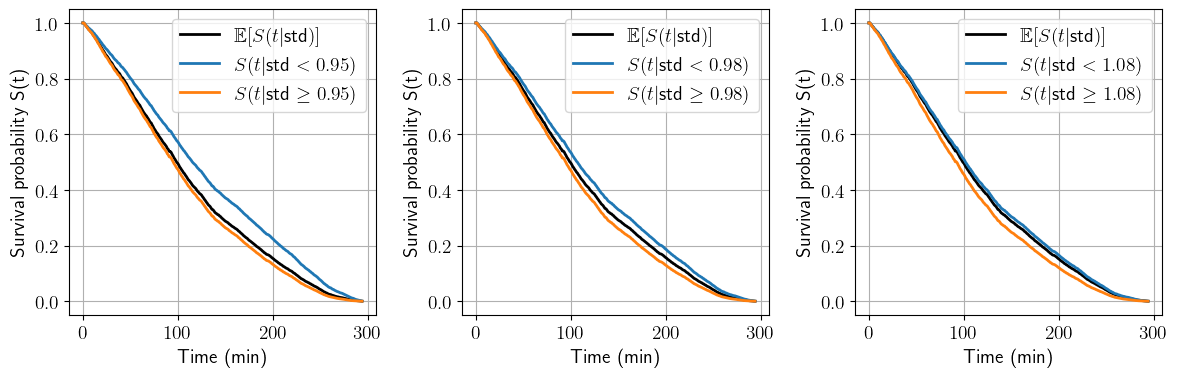

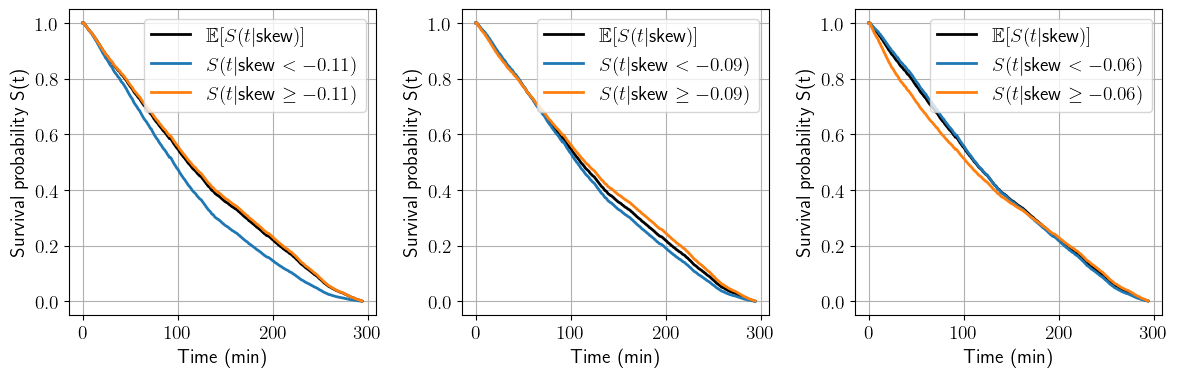

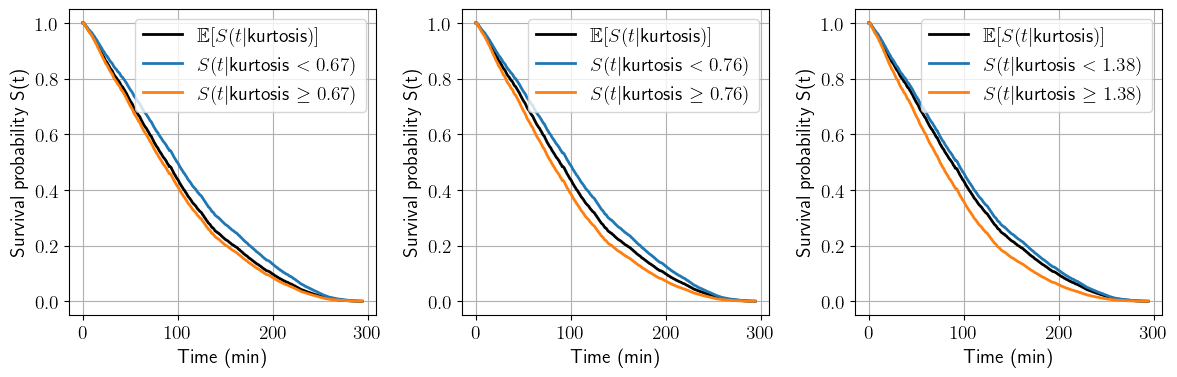

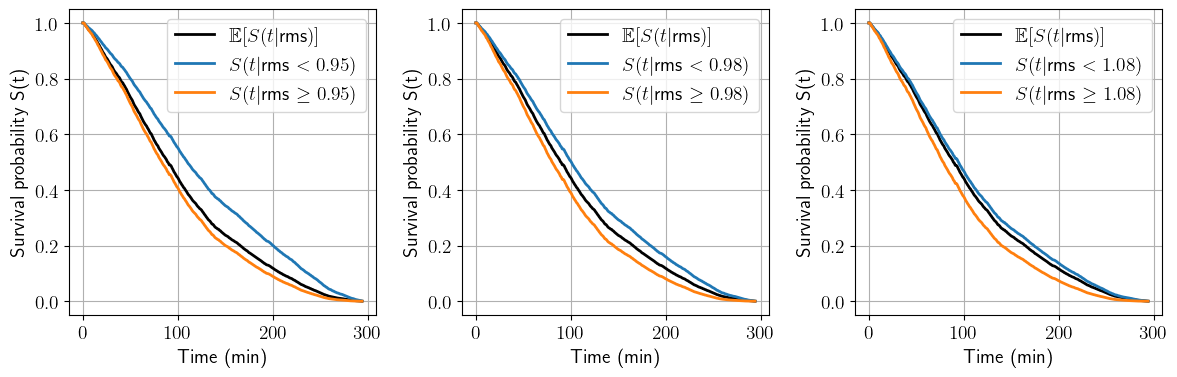

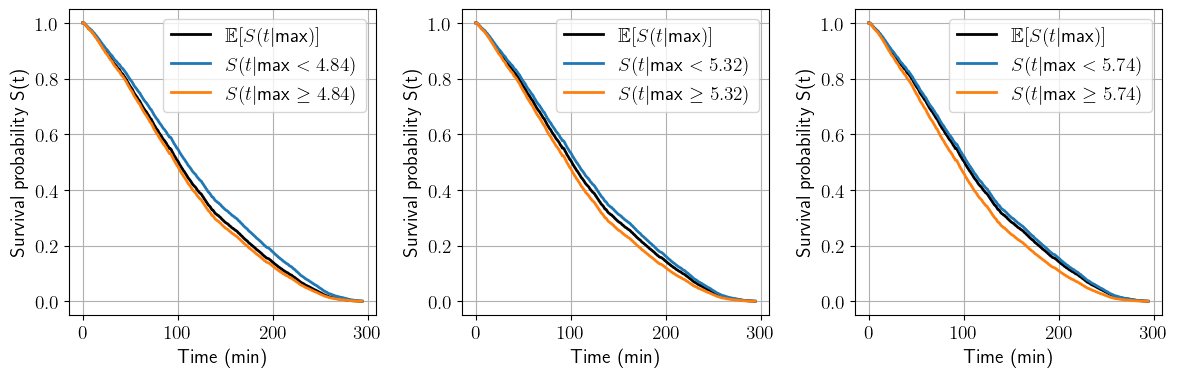

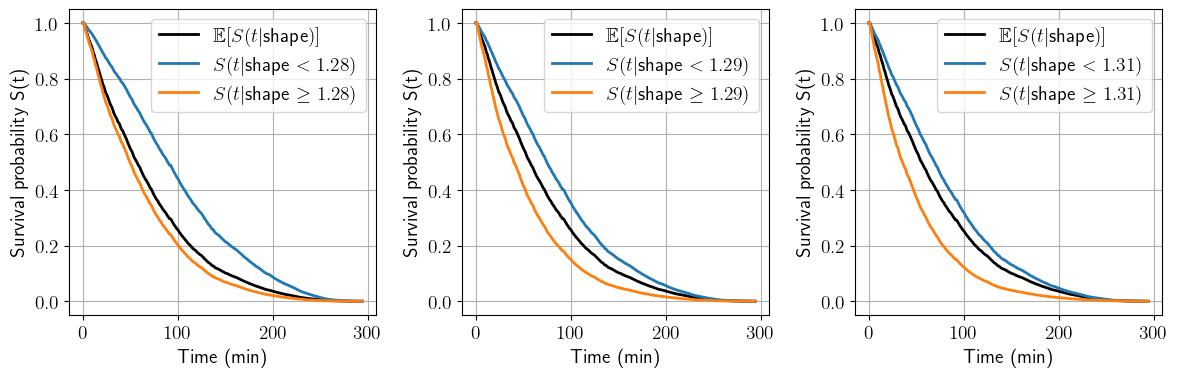

In [9]:
# Build timeseries data
test_condition = 1
timeseries_data, boot, info_pack = FileReader(dataset, DATASET_PATH).read_data(test_condition, n_boot)
window_size = get_window_size(test_condition)
lag = get_lag(test_condition)
train_idx = list(range(1, 7)) # bearings 1-6 for train
test_idx = list(range(7, 11)) # bearings 7-10 for test

train_data, test_data = pd.DataFrame(), pd.DataFrame()
for idx in train_idx:
    event_time = data_util.event_analyzer(idx, info_pack)
    transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
    train_data = pd.concat([train_data, transformed_data], axis=0)
for idx in test_idx:
    event_time = data_util.event_analyzer(idx, info_pack)
    transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
    test_data = pd.concat([test_data, transformed_data], axis=0)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
train_data = Formatter.add_random_censoring(train_data, percentage=0.25)
test_data = Formatter.add_random_censoring(test_data, percentage=0.25)
train_data = train_data.sample(frac=1, random_state=0)
test_data = test_data.sample(frac=1, random_state=0)

x_train = train_data.drop(['Event', 'Survival_time'], axis=1)
y_train = Surv.from_dataframe("Event", "Survival_time", train_data)
x_test = test_data.drop(['Event', 'Survival_time'], axis=1)
y_test = Surv.from_dataframe("Event", "Survival_time", test_data)

#Set event times for models
event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
event_times = np.unique(event_times)

#Set the feature selector and train/test split
best_features = PHSelector(x_train, y_train, estimator=[dataset, test_condition]).get_features()
X_train, X_test = x_train.loc[:,best_features], x_test.loc[:,best_features]

#Format the data for NN models
t_train = y_train['Survival_time']
e_train = y_train['Event']
t_test = y_test['Survival_time']
e_test = y_test['Event']

# Split data
features_to_split = best_features
for feature in features_to_split:
    X_train_feature, X_test_feature = pd.DataFrame(X_train[feature]), pd.DataFrame(X_test[feature])

    # Scale train data
    scaler = StandardScaler()
    scaler.fit(X_train_feature)
    X_train_scaled = scaler.transform(X_train_feature)

    #model.fit(X_train, y_train)
    model = BNNSurv().make_model(BNNSurv().get_best_hyperparams())
    #model = DeepSurv().make_model(DeepSurv().get_best_hyperparams())
    model.fit(X_train_scaled, t_train, e_train)
    split_thresholds = []
    for qct in [0.25, 0.5, 0.75]:
        split_thresholds.append(round(X_test_feature[feature].quantile(qct), 2))
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i, st in enumerate(split_thresholds):
        g1_idx = X_test_feature.loc[X_test_feature[feature] < st].index
        g2_idx = X_test_feature.loc[X_test_feature[feature] >= st].index
        X_test_g1 = X_test_feature.loc[g1_idx]
        X_test_g2 = X_test_feature.loc[g2_idx]
        y_test_g1 = y_test[g1_idx]
        y_test_g2 = y_test[g2_idx]

        # Scale splitted data
        X_test_scaled = scaler.transform(X_test_feature)
        X_test_g1_scaled = scaler.transform(X_test_g1)
        X_test_g2_scaled = scaler.transform(X_test_g2)

        # Predict for mean and two groups
        survival = Survival()
        surv_probs = survival.predict_survival_function(model, X_test_scaled, event_times,
                                                        n_post_samples=n_post_samples)
        km_mean, km_high, km_low = calculate_kaplan_vectorized(y_test['Survival_time'].reshape(1,-1),
                                                               y_test['Event'].reshape(1,-1),
                                                               event_times)
        surv_probs_g1 = survival.predict_survival_function(model, X_test_g1_scaled, event_times,
                                                           n_post_samples=n_post_samples)
        km_mean_g1, km_high_g1, km_low_g1 = calculate_kaplan_vectorized(y_test_g1['Survival_time'].reshape(1,-1),
                                                                        y_test_g1['Event'].reshape(1,-1),
                                                                        event_times)
        surv_probs_g2 = survival.predict_survival_function(model, X_test_g2_scaled, event_times,
                                                           n_post_samples=n_post_samples)
        
        surv_probs_mean = np.mean(surv_probs, axis=0)
        surv_probs_g1_mean = np.mean(surv_probs_g1, axis=0)
        surv_probs_g2_mean = np.mean(surv_probs_g2, axis=0)
        
        # Plot
        axes[i].plot(surv_probs_mean, linewidth=2, label=r"$\mathbb{E}[S(t|$" + f"{feature}" + r"$)]$", color="black")
        axes[i].plot(surv_probs_g1_mean, linewidth=2, label=r"$S(t|$" + f"{feature} $<{st})$", color="C0")
        axes[i].plot(surv_probs_g2_mean, linewidth=2, label=r"$S(t|$" + f"{feature} $\geq{st})$", color="C1")
        axes[i].set_xlabel("Time (min)")
        axes[i].set_ylabel("Survival probability S(t)")
        axes[i].legend(loc='upper right')
        axes[i].grid(True)
        fig.tight_layout()
        fig.show()
    plt.savefig(f'{plots_path}/group_survival_{feature}_cond_{test_condition+1}.pdf',
                format='pdf', bbox_inches="tight")

In [26]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
bearing_indicies =  list(range(1, (N_BEARING*2)+1)) # number of real bearings x2
for _, (train_idx, test_idx) in enumerate(kf.split(bearing_indicies)):
    print(f'{train_idx} - {test_idx}')

[2 3 4 5 6 7 8 9] - [0 1]
[0 1 4 5 6 7 8 9] - [2 3]
[0 1 2 3 6 7 8 9] - [4 5]
[0 1 2 3 4 5 8 9] - [6 7]
[0 1 2 3 4 5 6 7] - [8 9]


In [41]:
# Build timeseries data
test_condition = 1
timeseries_data, boot, info_pack = FileReader(dataset, DATASET_PATH).read_data(test_condition, n_boot)
window_size = get_window_size(test_condition)
lag = get_lag(test_condition)
train_idx = [3, 4, 5, 6, 7, 8, 9, 10]
test_idx = [1, 2]

train_data, test_data = pd.DataFrame(), pd.DataFrame()
for idx in train_idx:
    event_time = data_util.event_analyzer(idx, info_pack)
    transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
    train_data = pd.concat([train_data, transformed_data], axis=0)
for idx in test_idx:
    event_time = data_util.event_analyzer(idx, info_pack)
    transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
    test_data = pd.concat([test_data, transformed_data], axis=0)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
train_data = Formatter.add_random_censoring(train_data, percentage=0.25)
test_data = Formatter.add_random_censoring(test_data, percentage=0.25)
train_data = train_data.sample(frac=1, random_state=0)
test_data = test_data.sample(frac=1, random_state=0)

x_train = train_data.drop(['Event', 'Survival_time'], axis=1)
y_train = Surv.from_dataframe("Event", "Survival_time", train_data)
x_test = test_data.drop(['Event', 'Survival_time'], axis=1)
y_test = Surv.from_dataframe("Event", "Survival_time", test_data)

#Set event times for models
event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
event_times = np.unique(event_times)

#Set the feature selector and train/test split
best_features = PHSelector(x_train, y_train, estimator=[dataset, test_condition]).get_features()
X_train, X_test = x_train.loc[:,best_features], x_test.loc[:,best_features]

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Format the data for NN models
t_train = y_train['Survival_time']
e_train = y_train['Event']
t_test = y_test['Survival_time']
e_test = y_test['Event']

#Set up the models on test
model = BNNSurv().make_model(BNNSurv().get_best_hyperparams())

# Train the model
model.fit(X_train_scaled, t_train, e_train)

# Predict
surv_probs = model.predict_survival(X_test_scaled, event_times, n_post_samples)

In [42]:
# Computer coverage
credible_region_sizes = np.arange(0.1, 1, 0.1)
surv_times = torch.from_numpy(surv_probs)
coverage_stats = {}
for percentage in credible_region_sizes:
    drop_num = math.floor(0.5 * n_post_samples * (1 - percentage))
    lower_outputs = torch.kthvalue(surv_times, k=1 + drop_num, dim=0)[0]
    upper_outputs = torch.kthvalue(surv_times, k=n_post_samples - drop_num, dim=0)[0]
    coverage_stats[percentage] = coverage(event_times, upper_outputs, lower_outputs,
                                          t_test, e_test)
print("C-cal:", coverage_stats)

C-cal: {0.1: 0.20292887029288703, 0.2: 0.25313807531380755, 0.30000000000000004: 0.3106694560669456, 0.4: 0.35669456066945604, 0.5: 0.40585774058577406, 0.6: 0.4592050209205021, 0.7000000000000001: 0.5073221757322176, 0.8: 0.5596234309623431, 0.9: 0.6401673640167364}


In [96]:
import random
#Generate 5 random numbers between 10 and 30
randomlist = random.sample(range(10, 30), 9)
print(randomlist)

[25, 27, 18, 19, 28, 24, 16, 13, 10]


In [14]:
res = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
res2 = [0.15, 0.25, 0.35, 0.45, 0.55, 0.55, 0.5, 0.5, 0.5]

In [15]:
from scipy.stats._stats_py import chisquare
 
# defining the table
data = [res, res2]
_, pvalue = chisquare(data)

# interpret p-value
alpha = 0.05
p = pvalue[0]
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.920344325445942
Independent (H0 holds true)


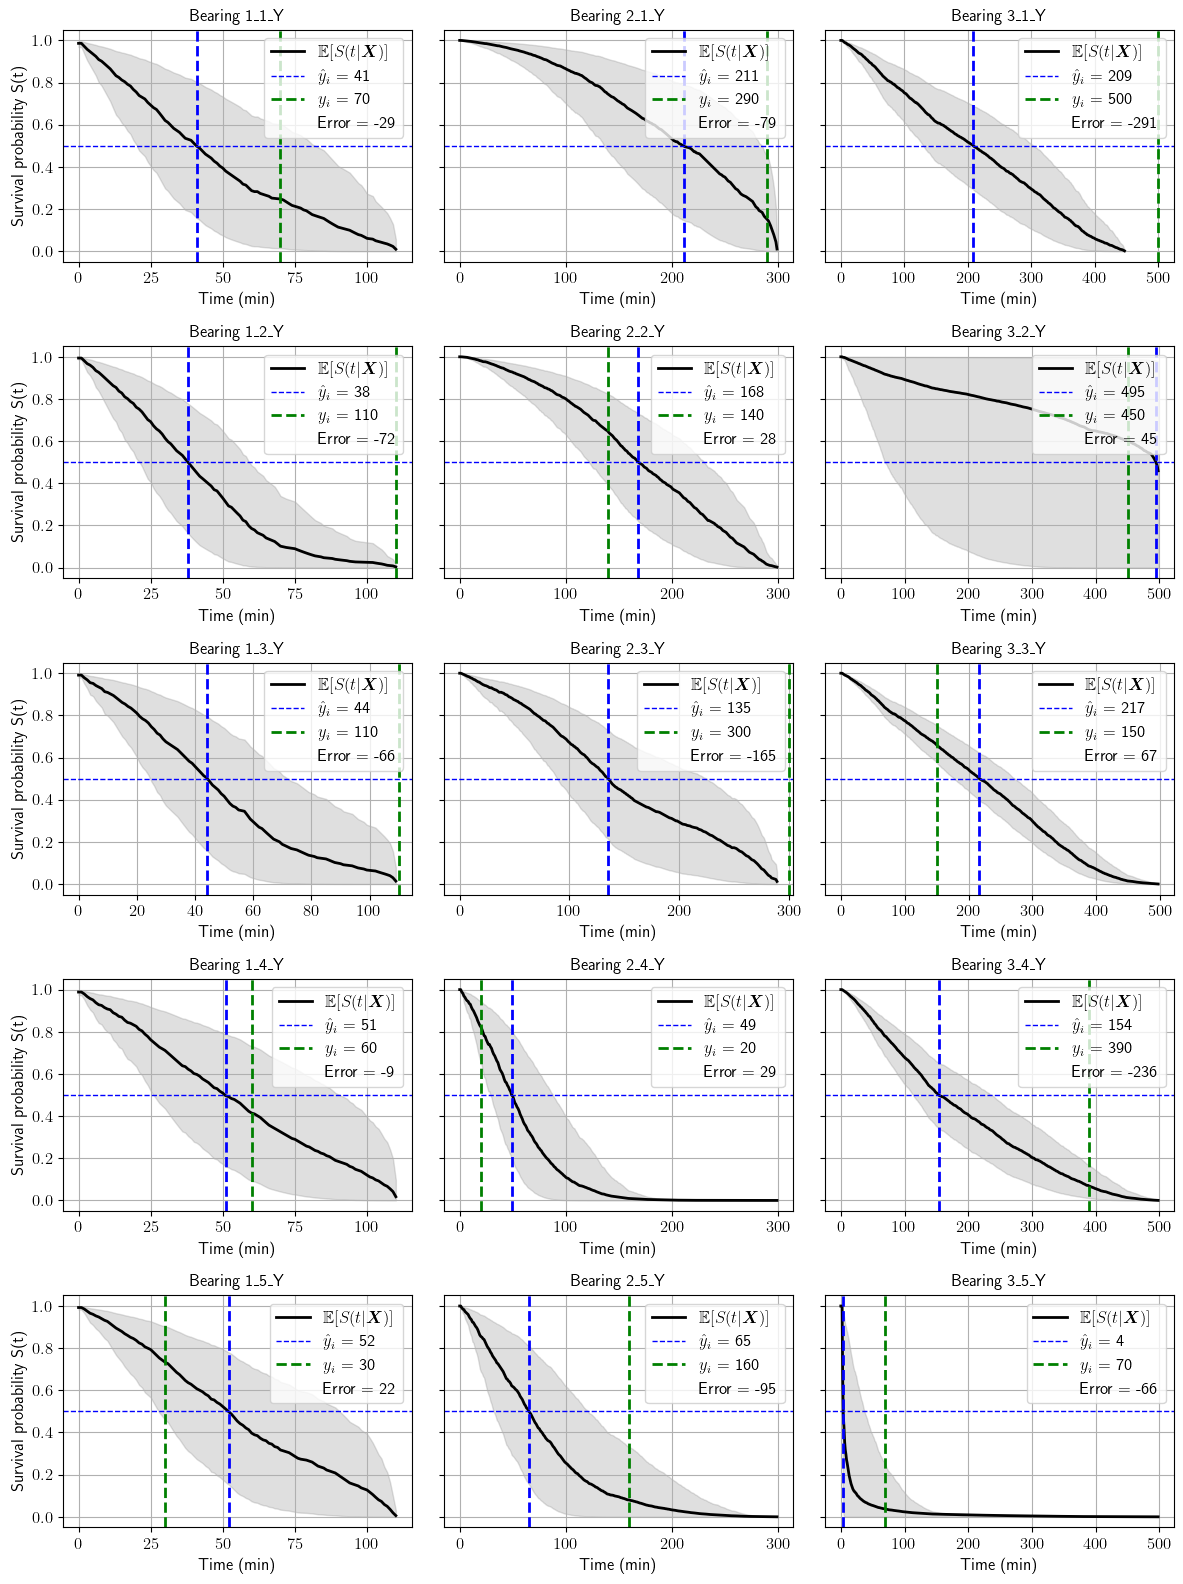

In [67]:
matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 12.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

from matplotlib.patches import Rectangle

data_util = DataETL(dataset, n_boot)
fig, axes = plt.subplots(5, 3, figsize=(12, 16), sharey=True)

x_bearings = [idx for idx in list(range(1, 11)) if idx % 2 != 0]
y_bearings = [idx for idx in list(range(1, 11)) if idx % 2 == 0]

for test_condition in [0, 1, 2]:
    # Build timeseries data
    timeseries_data, boot, info_pack = FileReader(dataset, DATASET_PATH).read_data(test_condition, n_boot)
    window_size = get_window_size(test_condition)
    lag = get_lag(test_condition)
    
    # Individual bearing prediction
    bearings = y_bearings
    plot_indicies = [0, 1, 2, 3, 4]
    for test_idx, plot_idx in zip(bearings, plot_indicies):
        train_idx = [x for x in bearings if x != test_idx]
        
        train_data = pd.DataFrame()
        for idx in train_idx:
            event_time = data_util.event_analyzer(idx, info_pack)
            transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
            train_data = pd.concat([train_data, transformed_data], axis=0)
            
        test_event_time = data_util.event_analyzer(test_idx, info_pack)
        test_data = data_util.make_moving_average(timeseries_data, test_event_time, test_idx, window_size, lag)
    
        train_data = train_data.reset_index(drop=True)
        test_data = test_data.reset_index(drop=True)
        
        train_data = Formatter.add_random_censoring(train_data, percentage=0.25)
        test_data = Formatter.add_random_censoring(test_data, percentage=0.25)
        train_data = train_data.sample(frac=1, random_state=0)
        test_data = test_data.sample(frac=1, random_state=0)
        
        # Select only first observation
        test_sample = test_data[test_data['Survival_time'] == test_data['Survival_time'].max()] \
                     .drop_duplicates(subset="Survival_time")

        x_train = train_data.drop(['Event', 'Survival_time'], axis=1)
        y_train = Surv.from_dataframe("Event", "Survival_time", train_data)
        x_test = test_sample.drop(['Event', 'Survival_time'], axis=1)
        y_test = Surv.from_dataframe("Event", "Survival_time", test_sample)

        #Set event times for models
        event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
        event_times = np.unique(event_times)

        #Set the feature selector and train/test split
        best_features = PHSelector(x_train, y_train, estimator=[dataset, test_condition]).get_features()
        X_train, X_test = x_train.loc[:,best_features], x_test.loc[:,best_features]

        # Scale data
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        #Format the data
        t_train = y_train['Survival_time']
        e_train = y_train['Event']
        t_test = y_test['Survival_time']
        e_test = y_test['Event']
        
        # Set event time
        failure_time = data_util.event_analyzer(test_idx, info_pack)
        
        #Set up the models on test
        model = BNNSurv().make_model(BNNSurv().get_best_hyperparams())

        # Train the model
        model.fit(X_train_scaled, t_train, e_train)
        
        # Predict
        surv_probs = model.predict_survival(X_test_scaled, event_times, n_post_samples)
        median_outputs = pd.DataFrame(np.mean(surv_probs, axis=0), columns=event_times)
        
        # Calculate TTE
        lifelines_eval = LifelinesEvaluator(median_outputs.T, t_test, e_test, t_train, e_train)
        median_survival_time = round(np.median(lifelines_eval.predict_time_from_curve(predict_median_survival_time)))
        
        # Plot
        p1 = axes[plot_idx, test_condition].plot(np.mean(median_outputs, axis=0).T, linewidth=2, label=r"$\mathbb{E}[S(t|\bm{X})]$", color="black")
        drop_num = math.floor(0.5 * n_post_samples * (1 - 0.9))
        lower_outputs = torch.kthvalue(torch.from_numpy(surv_probs), k=1+drop_num, dim=0)[0]
        upper_outputs = torch.kthvalue(torch.from_numpy(surv_probs), k=n_post_samples-drop_num, dim=0)[0]
        axes[plot_idx, test_condition].fill_between(event_times, upper_outputs[0,:], lower_outputs[0,:], color="gray", alpha=0.25)
        p2 = axes[plot_idx, test_condition].axhline(y=0.5, linestyle= "dashed", color='blue', linewidth=1, label='$\hat{y}_{i}$ = ' + f'{median_survival_time}')        
        p3 = axes[plot_idx, test_condition].axvline(x=test_event_time, linestyle= "dashed",
                                          color='green', linewidth=2.0, label=f'$y_i$ = {int(test_event_time)}')
        axes[plot_idx, test_condition].axvline(x=int(median_survival_time), linestyle= "dashed", color='blue', linewidth=2.0)
        axes[plot_idx, test_condition].set_title(f'Bearing {test_condition+1}_{plot_idx+1}_Y')
        axes[plot_idx, test_condition].set_xlabel("Time (min)")
        text = f'Error = {int(median_survival_time-test_event_time)}'
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        axes[plot_idx, test_condition].legend([p1[0], p2, p3, extra], [p1[0].get_label(), p2.get_label(), p3.get_label(), text], loc='upper right')
        if test_condition == 0:
            axes[plot_idx, test_condition].set_ylabel("Survival probability S(t)")
        axes[plot_idx, test_condition].grid(True)
plt.tight_layout()
plt.savefig(f'{plots_path}/individual_survival_axis_y.pdf', format='pdf', bbox_inches="tight")